# Midterm Exam

## ref:
- https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=cQmJd7RvB4A-
- https://medium.com/analytics-vidhya/finetune-distilbert-for-multi-label-text-classsification-task-994eb448f94c
- https://arxiv.org/pdf/1804.07612.pdf
- https://forums.fast.ai/t/the-bs-32-paper/38935
- https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/
- https://huggingface.co/docs/transformers/model_doc/distilbert
- https://medium.com/@ayikfurkan1/mastering-text-classification-with-bert-a-comprehensive-guide-194ddb2aa2e5
- https://medium.com/huggingface/distilbert-8cf3380435b5

## Import Library

In [1]:
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from transformers import DistilBertTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from IPython.display import clear_output
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from nltk.stem import WordNetLemmatizer

/Users/jackkahod/anaconda3/envs/datasci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
EPOCHS = 75
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
LEARNING_RATE = 5e-05
EPSILON=1e-8

MAX_LENGTH = 128

## Data Preprocessing

In [3]:
all_class = ["CE", "ENV", "BME", "PE", "METAL", "ME", "EE", "CPE", "OPTIC", "NANO", "CHE", "MATENG", "AGRI", "EDU", "IE", "SAFETY", "MATH", "MATSCI" ]

## Making dict for accessing index

In [4]:
dict_class = {}
for c in all_class:
    dict_class[c] = len(dict_class)

dict_class

{'CE': 0,
 'ENV': 1,
 'BME': 2,
 'PE': 3,
 'METAL': 4,
 'ME': 5,
 'EE': 6,
 'CPE': 7,
 'OPTIC': 8,
 'NANO': 9,
 'CHE': 10,
 'MATENG': 11,
 'AGRI': 12,
 'EDU': 13,
 'IE': 14,
 'SAFETY': 15,
 'MATH': 16,
 'MATSCI': 17}

## Import data

In [5]:
import json

with open('../data/train_for_student.json') as json_file:
  data = json.load(json_file)

## Convert data json to dataframe

In [6]:
df = pd.DataFrame(columns=["ID", "Title", "Abstract","Labels"])

## Group class to labels column

In [7]:
for idx, (key, value) in enumerate(data.items()):
  row = {
    "ID": key,
    "Title": value["Title"],
    "Abstract": value["Abstract"],
    "Labels": [0 for _ in range(18)]
  }

  for cls in all_class:
    row['Labels'][dict_class[cls]] = 1 if cls in value["Classes"] else 0
  
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

df

,ID,Title,Abstract,Labels
0,001,Activated carbon derived from bacterial cellul...,© 2019 Elsevier B.V.Activated carbon derived f...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
1,002,The algorithm of static hand gesture recogniti...,© Springer International Publishing AG 2018.Te...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,003,Alternative Redundant Residue Number System Co...,© 2018 IEEE.Residue number system (RNS) is a n...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,004,Comparative study of wax inhibitor performance...,© Published under licence by IOP Publishing Lt...,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,005,Undrained lower bound solutions for end bearin...,"© 2019 John Wiley & Sons, Ltd.The undrained be...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
449,450,A portable USB-controlled potentiostat for pap...,© 2018 IEEEThis paper presents a portable and ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
450,451,Literature reviews on applying artificial inte...,Copyright © 2019 for this paper by its authors...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
451,452,A multi-parameterized water quality prediction...,© 2019 The authors and IOS Press. All rights r...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ..."
452,453,Semantic Segmentation on Medium-Resolution Sat...,© 2018 IEEE.Semantic Segmentation is a fundame...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, ..."


In [8]:
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "n't" to "not"
    - Remove specified word
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove trailing whitespace
    """
    # Lowercase the sentence
    s = s.lower()
    
    # Change "'t" to " not"
    s = re.sub(r"n't", " not", s)
    
    # Remove specified word
    word_to_remove=['the','of','and','to','in',
                    'a','for','is','with','on',
                    'that','by','this','as','was',
                    'from','are','were','using','an',
                    'at','be','2018','2019']
    
    if len(word_to_remove) > 0:
        for w in word_to_remove:
            s = re.sub(r'\b' + re.escape(w) + r'\b', '', s)
    
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jackkahod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jackkahod/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jackkahod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jackkahod/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jackkahod/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
df_clean = df.copy()
df_clean["Title"] = df["Title"].apply(text_preprocessing)
df_clean["Abstract"] = df["Abstract"].apply(text_preprocessing)

df_clean

,ID,Title,Abstract,Labels
0,001,activated carbon derived bacterial cellulose i...,elsevier b v activated carbon derived bacteria...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
1,002,algorithm static hand gesture recognition rule...,springer international publishing ag technolog...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,003,alternative redundant residue number system co...,ieee residue number system rns number represen...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,004,comparative study wax inhibitor performance po...,published under licence iop publishing ltd pet...,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,005,undrained lower bound solutions end bearing ca...,john wiley sons ltd undrained bearing capacity...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
449,450,portable usb controlled potentiostat paper bas...,ieeethis paper presents portable inexpensive u...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
450,451,literature reviews applying artificial intelli...,copyright paper its authors use permitted unde...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
451,452,multi parameterized water quality prediction m...,authors ios press all rights reserved paper pr...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ..."
452,453,semantic segmentation medium resolution satell...,ieee semantic segmentation fundamental task co...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, ..."


## Prepare tokenizer

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

## Prepare the Dataset and Dataloader

In [12]:
class MultiLabelDataset(Dataset):
    
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe.Title
        self.abstract = dataframe.Abstract
        self.targets = self.data.Labels
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        abstract = str(self.abstract[index])
        abstract = " ".join(abstract.split())

        inputs = self.tokenizer.encode_plus(
            title,
            abstract,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [13]:
class MultiLabelDatasetForTesting(Dataset):
    
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe.Title
        self.abstract = dataframe.Abstract
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        abstract = str(self.abstract[index])
        abstract = " ".join(abstract.split())

        inputs = self.tokenizer.encode_plus(
            title,
            abstract,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [14]:
# Creating the dataset and dataloader for the neural network
train_size = 0.8
train_data=df_clean.sample(frac=train_size,random_state=428)
test_data=df_clean.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(df_clean.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, MAX_LENGTH)
testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LENGTH)

FULL Dataset: (454, 4)
TRAIN Dataset: (363, 4)
TEST Dataset: (91, 4)


In [15]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Making model

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import DistilBertModel


class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(768, 18)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [17]:
# Macbook Pro M2 MAX 32GB/1TB Silver
device = "mps"

model = DistilBERTClass()
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)

## Train model

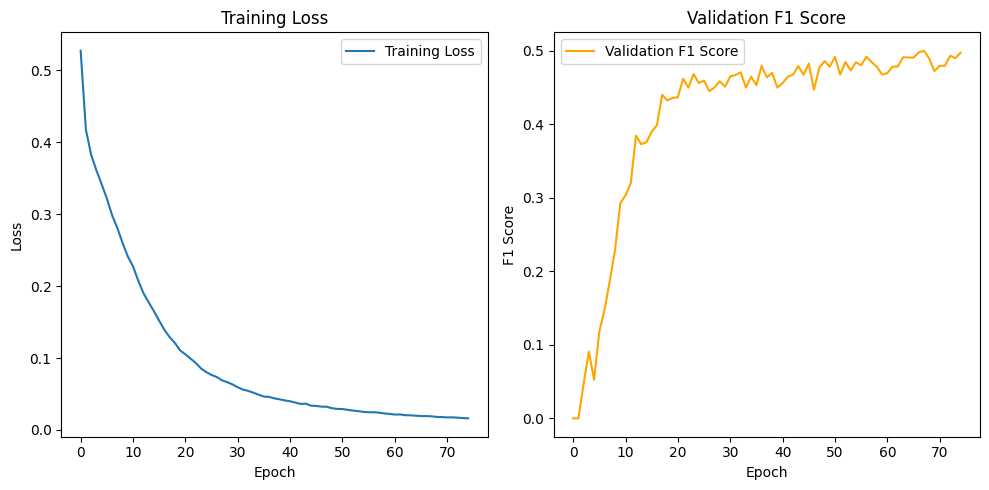

Epoch 75/75, Training Loss: 0.0161, Validation F1: 0.4973


In [18]:
train_losses = []
val_f1_scores = []
best_f1_score = 0
best_treshold = 0

for epoch in range(EPOCHS):

  model.train()
  train_loss_accum = 0
  
  for data in tqdm(training_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)
        
    output = model(ids, mask, token_type_ids)

    optimizer.zero_grad()
    train_loss = criterion(output, targets)

    train_loss.backward()
    optimizer.step()

    train_loss_accum += train_loss.item()

  avg_train_loss = train_loss_accum / len(training_loader)
  train_losses.append(avg_train_loss)

  model.eval()
  val_preds = []
  val_labels = []
  
  with torch.no_grad():
    for data in tqdm(testing_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
      
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)
      output = model(ids, mask, token_type_ids)
      
      output_binary = (output > 0.5).float()
      
      val_preds.extend(output_binary.cpu().numpy())
      val_labels.extend(targets.cpu().numpy())
      
      val_loss = criterion(output, targets)
    
      
  f1_macro = f1_score(val_labels, val_preds, average='macro')
  val_f1_scores.append(f1_macro)

  if f1_macro > best_f1_score:
    best_f1_score = f1_macro
    torch.save(model.state_dict(), 'best_model.pth')  # Save best model

  clear_output(wait=True)
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
  plt.xlabel('Epoch')
  plt.ylabel('F1 Score')
  plt.title('Validation F1 Score')
  plt.legend()

  plt.tight_layout()
  plt.show()

  print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {avg_train_loss:.4f}, Validation F1: {f1_macro:.4f}")

## Evaluate Model

In [19]:
# Display the best F1 score after training completes
best_f1_epoch = val_f1_scores.index(max(val_f1_scores)) + 1
print(f"Best Validation F1 Score: {max(val_f1_scores):.4f} at Epoch: {best_f1_epoch}")

# Load the best model based on validation F1 score
model.load_state_dict(torch.load('best_model.pth'))

Best Validation F1 Score: 0.4999 at Epoch: 68


<All keys matched successfully>

In [20]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

outputs, targets = validation(testing_loader)

0it [00:00, ?it/s]/Users/jackkahod/anaconda3/envs/datasci/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some 

## Find threshold to fit this model

In [21]:
def get_f1_from_threshold(outputs, targets, threshold):
    
    final_outputs = np.array(outputs) >=threshold
    
    f1_macro = f1_score(final_outputs, targets, average='macro')
    
    return f1_macro
    

0.14
0.6150739430743806


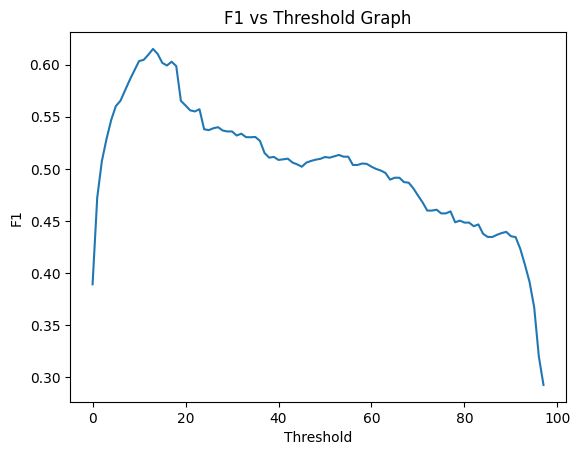

0.14
0.6150739430743806


In [22]:
from sklearn.metrics import f1_score
from IPython.display import clear_output

best_threshold = 0.01
best_f1 = 0
f1_data = []

for t in np.arange(0.01,0.99,0.01):
    f1 = get_f1_from_threshold(outputs, targets,t)
    f1_data.append(f1)
    if(best_f1 < f1):
        best_threshold = t
        best_f1 = f1
    
    clear_output()

    print(best_threshold)
    print(best_f1)

    plt.plot(f1_data)
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.title('F1 vs Threshold Graph')
    plt.show()
 

print(best_threshold)
print(best_f1)

## Predict Result

In [23]:
import json

with open('../data/test_for_student.json') as json_file:
  test_data = json.load(json_file)

test_df = pd.DataFrame(columns=["id", "Title", "Abstract"])

for idx, (key, value) in enumerate(test_data.items()):
  row = {
    "id": key,
    "Title": value["Title"],
    "Abstract": value["Abstract"]
  }
  
  test_df = pd.concat([test_df, pd.DataFrame([row])], ignore_index=True)

test_df_clean = test_df.copy()
test_df_clean["Title"] = test_df["Title"].apply(text_preprocessing)
test_df_clean["Abstract"] = test_df["Abstract"].apply(text_preprocessing)


last_testing_set = DataLoader(MultiLabelDatasetForTesting(test_df_clean, tokenizer, MAX_LENGTH))

predictions = []

for data in tqdm(last_testing_set):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      output = model(ids, mask, token_type_ids)
      predictions.extend(torch.sigmoid(output).cpu().detach().numpy().tolist())

clear_output()

test_df_result = pd.DataFrame(columns=all_class)

for index, prediction in enumerate(predictions):
  prediction_labels = (np.array(prediction) > best_threshold).astype(int).flatten()
  # print(len(prediction))

  test_df_result.loc[index+1] = prediction_labels

test_df_result.insert(0, "id", test_df_clean.id.tolist(), allow_duplicates=True)

test_df_result

,id,CE,ENV,BME,PE,METAL,ME,EE,CPE,OPTIC,NANO,CHE,MATENG,AGRI,EDU,IE,SAFETY,MATH,MATSCI
1,001eval,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
2,002eval,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1
3,003eval,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,004eval,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
5,005eval,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,147eval,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1
148,148eval,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
149,149eval,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0
150,150eval,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


## Save the result file

In [24]:
import datetime

# Get current timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Append timestamp and f1 score to filename
filename = f"result_{timestamp}_f1_{int(best_f1*100)}.csv"

# Save DataFrame to CSV with timestamped filename
test_df_result.to_csv(filename, index=False)